In [1]:
# importing file from local system "kaggle.json"
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kevinwaghela","key":"97cd315288631d4edc984f8a40fcee3f"}'}

In [2]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 68 Feb  8 11:33 kaggle.json


In [3]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [4]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# downloading dataset in zip from kaggle 
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

100% 2.70G/2.70G [00:36<00:00, 58.4MB/s]
100% 2.70G/2.70G [00:36<00:00, 78.5MB/s]


In [ ]:
# unzipping dataset
!unzip /content/new-plant-diseases-dataset.zip -d /content

In [7]:
# improrting important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# importing deep learning libraries
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

# setting random seed so that we can get same result every time we run
np.random.seed(1)
tf.random.set_seed(2)

In [8]:
# importing pillow for importing images
from PIL import Image

im = Image.open('/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/023123cb-7b69-4c9f-a521-766d7c8543bb___FREC_Scab 3487_270deg.JPG')
print(im.size)

(256, 256)


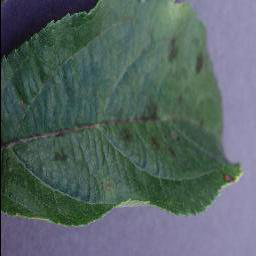

In [9]:
im

In [10]:
# applying image augmentation on our train dataset
train_datagen = ImageDataGenerator(rescale=1./255,        #normalizing every pixels 
                                   shear_range=0.2,      
                                   zoom_range=0.2,
                                   horizontal_flip=True)
training_set = train_datagen.flow_from_directory('/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='categorical')

Found 70295 images belonging to 38 classes.


In [11]:
# applying image augmentation on our validation dataset
validate_datagen = ImageDataGenerator(rescale=1./255)     #normalizing every pixels
                                
validation_set = validate_datagen.flow_from_directory('/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid',
                                                   target_size=(224,224),
                                                   batch_size=32,
                                                   class_mode='categorical')

Found 17572 images belonging to 38 classes.


# **Training Using MobileNetV2**

In [12]:
# importing mobilenet from keras
mobilenet_model = keras.applications.MobileNet(weights='imagenet', input_shape=(224,224,3), include_top=False)

17235968/17225924 [==============================] - 0s 0us/step


In [13]:
# set training to false
mobilenet_model.trainable = False

# defining input shape
inputs = keras.Input(shape=(224,224,3))

# initializing mobilenet model
cnn = mobilenet_model(inputs, training=False)
# adding global average pooling layer after last layer of mobilenet model
cnn = keras.layers.GlobalAveragePooling2D()(cnn)
# set dropout to 20 percent so that our model can not memorize the exact pattern of training data
cnn = keras.layers.Dropout(0.2)(cnn)
# defining output layer and set neuron to 38 since we have a 38 different plant categories
outputs = keras.layers.Dense(38)(cnn)

# feeding inputs and outputs to the model
mobilenet_model = keras.Model(inputs, outputs, name='mobilenet')
# seeing summray of the model which layer architecture
mobilenet_model.summary()

Model: "mobilenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 38)                38950     
                                                                 
Total params: 3,267,814
Trainable params: 38,950
Non-trai

In [14]:
# compiling model with adam optimizer and categorical crossentropy loss function
mobilenet_model.compile(optimizer='adam',
                        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy'])

In [15]:
# start training for 25 epochs
mobilenet_history = mobilenet_model.fit(training_set,
                                        steps_per_epoch=150,
                                        validation_data=validation_set,
                                        epochs=25,
                                        validation_steps=100)

Epoch 1/25
150/150 [==============================] - 79s 459ms/step - loss: 1.8573 - accuracy: 0.5092 - val_loss: 0.7467 - val_accuracy: 0.8087
Epoch 2/25
150/150 [==============================] - 69s 462ms/step - loss: 0.6776 - accuracy: 0.8142 - val_loss: 0.4658 - val_accuracy: 0.8797
Epoch 3/25
150/150 [==============================] - 69s 462ms/step - loss: 0.4943 - accuracy: 0.8598 - val_loss: 0.3765 - val_accuracy: 0.8928
Epoch 4/25
150/150 [==============================] - 69s 463ms/step - loss: 0.3863 - accuracy: 0.8946 - val_loss: 0.2968 - val_accuracy: 0.9156
Epoch 5/25
150/150 [==============================] - 69s 459ms/step - loss: 0.3347 - accuracy: 0.9010 - val_loss: 0.2574 - val_accuracy: 0.9225
Epoch 6/25
150/150 [==============================] - 69s 459ms/step - loss: 0.2929 - accuracy: 0.9117 - val_loss: 0.2239 - val_accuracy: 0.9384
Epoch 7/25
150/150 [==============================] - 68s 456ms/step - loss: 0.2756 - accuracy: 0.9169 - val_loss: 0.2320 - val_ac

In [16]:
# evaluating how our model perform on training set
mobilenet_result = mobilenet_model.evaluate(validation_set)

550/550 [==============================] - 53s 96ms/step - loss: 0.1385 - accuracy: 0.9538


In [17]:
# printing validation loss and validation accuracy
print('Val Loss: ', mobilenet_result[0])
print('Val Accuracy: ', mobilenet_result[1])

Val Loss:  0.1385369896888733
Val Accuracy:  0.9538470506668091


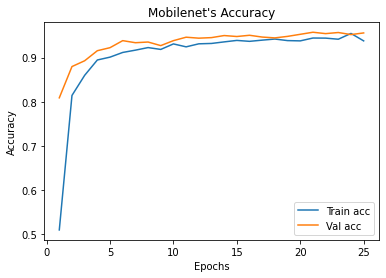

In [18]:
# plotting training and validation accuracy using matplotlib
train_acc = mobilenet_history.history['accuracy']
val_acc = mobilenet_history.history['val_accuracy']

epochs_list = list(range(1, 25 + 1))

plt.plot(epochs_list, train_acc, label='Train acc')
plt.plot(epochs_list, val_acc, label='Val acc')

plt.title("Mobilenet's Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

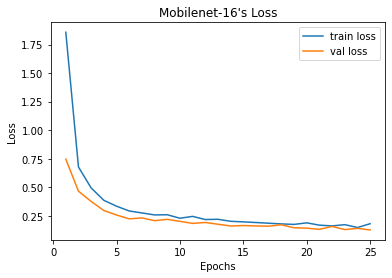

In [19]:
# plotting training and validation loss using matplotlib
train_loss = mobilenet_history.history['loss']
val_loss = mobilenet_history.history['val_loss']

plt.plot(epochs_list, train_loss, label='train loss')
plt.plot(epochs_list, val_loss, label='val loss')
plt.title("Mobilenet-16's Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

In [20]:
# saving our mobilenet model 
mobilenet_model.save('mobilenet_model.h5')